## Visualizing gating variables in a LSTM

Here we will train a one-unit LSTM network and visualize its gating variables.

In [164]:
import numpy as np

def memory_task(seq_length, batch_size):
    """Return a batch from a simple memory task."""
    inputs = np.zeros((seq_length, batch_size, 3))
    outputs = np.zeros((seq_length, batch_size, 1))

    inputs[:, :, 0] = np.random.rand(seq_length, batch_size)
    t_stim = np.random.randint(int(seq_length)/2, size=(batch_size,))
    t_test = np.random.randint(int(seq_length)/2, seq_length-1, size=(batch_size,))
    inputs[t_stim, range(batch_size), 1] = 1
    inputs[t_test, range(batch_size), 2] = 1
    
    outputs[t_test, range(batch_size), 0] = inputs[t_stim, range(batch_size), 0]
    
    return inputs, outputs

([<matplotlib.axis.YTick at 0x12d54de90>],
 <a list of 1 Text yticklabel objects>)

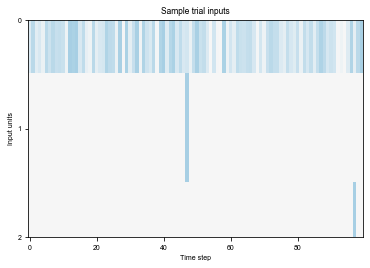

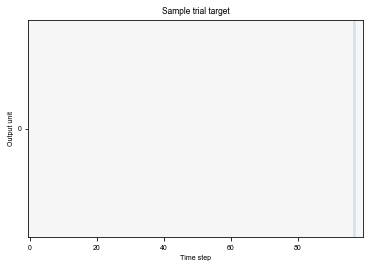

In [165]:
import matplotlib.pyplot as plt

inputs, outputs = memory_task(seq_length=100, batch_size=32)

plt.figure()
plt.imshow(inputs[:, 0, :].T, aspect='auto', vmin=-3, vmax=3, cmap='RdBu')
# plt.plot(inputs[:, 0, :].T)
plt.title('Sample trial inputs')
plt.xlabel('Time step')
plt.ylabel('Input units')
plt.yticks([0, 1, 2])

plt.figure()
plt.imshow(outputs[:, 0, :].T, aspect='auto', vmin=-3, vmax=3, cmap='RdBu')
plt.title('Sample trial target')
plt.xlabel('Time step')
plt.ylabel('Output unit')
plt.yticks([0])

###  Defining a LSTM network

Here we define a LSTM network explicitly using raw pytorch so we can access its gating variables.

In [166]:
import torch
import torch.nn as nn


class MyLSTM(nn.Module):
    """Manual implementation of LSTM."""

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input2h = nn.Linear(input_size, 4*hidden_size)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size)
        
        self.readout = False  # whether to readout activity

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        
        hx, cx = hidden
        gates = self.input2h(input) + self.h2h(hx)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, dim=1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)
        
        if self.readout:
            return (hy, cy), (ingate, outgate, forgetgate)
        else:
            return hy, cy

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input)

        if not self.readout:
            # Regular forward
            output = []
            for i in range(input.size(0)):
                hidden = self.recurrence(input[i], hidden)
                output.append(hidden[0])

            output = torch.stack(output, dim=0)
            return output, hidden

        else:
            output = []
            ingate, outgate, forgetgate = [], [], []
            for i in range(input.size(0)):
                hidden, gates = self.recurrence(input[i], hidden)
                output.append(hidden[0])
                ingate.append(gates[0])
                outgate.append(gates[1])
                forgetgate.append(gates[2])
                
            output = torch.stack(output, dim=0)
            ingate = torch.stack(ingate, dim=0)
            outgate = torch.stack(outgate, dim=0)
            forgetgate = torch.stack(forgetgate, dim=0)
            return output, hidden, (ingate, outgate, forgetgate)
    

class Net(nn.Module):
    """Recurrent network model."""
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # self.rnn = nn.LSTM(input_size, hidden_size, **kwargs)
        self.rnn = MyLSTM(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        out = self.fc(rnn_activity)
        return out, rnn_activity

In [167]:
import torch.optim as optim
import time

# Using custom LSTM, ~30% slower on CPUs compare to native LSTM
# net = nn.LSTM(input_size=3, hidden_size=1)
# net = MyLSTM(input_size=3, hidden_size=1)
net = Net(input_size=3, hidden_size=1, output_size=1)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

running_loss = 0
start_time = time.time()

for i in range(10000):    
    inputs, labels = memory_task(seq_length=10, batch_size=16)
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels).type(torch.float)

    optimizer.zero_grad()   # zero the gradient buffers
    output, activity = net(inputs)
    
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    if i % 400 == 399:
        running_loss /= 400
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
#         print('Time per step {:0.3f}ms'.format((time.time()-start_time)/i*1e3))
        running_loss = 0

Step 400, Loss 0.0780
Step 800, Loss 0.0086
Step 1200, Loss 0.0085
Step 1600, Loss 0.0084
Step 2000, Loss 0.0083
Step 2400, Loss 0.0083
Step 2800, Loss 0.0082
Step 3200, Loss 0.0082
Step 3600, Loss 0.0083
Step 4000, Loss 0.0077
Step 4400, Loss 0.0014
Step 4800, Loss 0.0005
Step 5200, Loss 0.0003
Step 5600, Loss 0.0002
Step 6000, Loss 0.0002
Step 6400, Loss 0.0001
Step 6800, Loss 0.0001
Step 7200, Loss 0.0001
Step 7600, Loss 0.0001
Step 8000, Loss 0.0001
Step 8400, Loss 0.0001
Step 8800, Loss 0.0000
Step 9200, Loss 0.0000
Step 9600, Loss 0.0000
Step 10000, Loss 0.0000


In [190]:
rnn = net.rnn

rnn.readout = True

inputs, labels = memory_task(seq_length=20, batch_size=16)
inputs = torch.from_numpy(inputs).type(torch.float)

with torch.no_grad():
    rnn_activity, _, gates = rnn(inputs)
    output = net.fc(rnn_activity)
ingate, outgate, forgetgate = gates

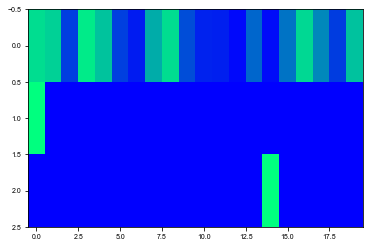

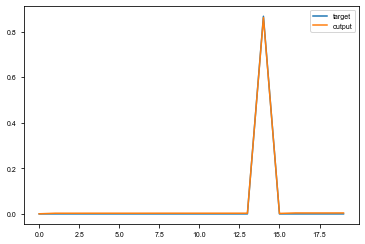

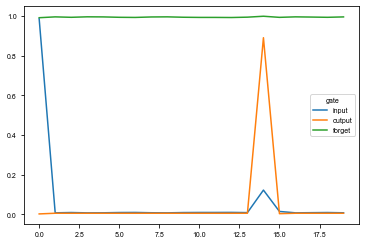

In [198]:
i_trial = 3
plt.figure()
plt.imshow(inputs[:, i_trial, :].T, aspect='auto', cmap='winter')

plt.figure()
plt.plot(labels[:, i_trial, 0], label='target')
plt.plot(output.detach()[:, i_trial, 0], label='output')
plt.legend()

plt.figure()
plt.plot(ingate[:, i_trial, 0], label='input')
plt.plot(outgate[:, i_trial, 0], label='output')
plt.plot(forgetgate[:, i_trial, 0], label='forget')
plt.legend(title='gate')

# Supplementary Materials

Code for making publication quality figures as it appears in the paper.

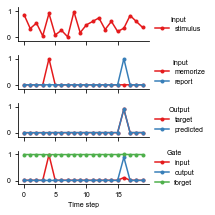

In [196]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 7
mpl.rcParams['font.family'] = 'arial'

i_trial = 1

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(3, 3))
for i in range(4):
    ax = axes[i]
    kwargs = {'marker': 'o', 'markersize': 3}
    cmap = mpl.cm.get_cmap('Set1')
    title = None
    if i == 0:
        ax.plot(inputs[:, i_trial, 0], label='stimulus', color=cmap(0), **kwargs)
        title = 'Input'
    elif i == 1:
        ax.plot(inputs[:, i_trial, 1], label='memorize', color=cmap(0), **kwargs)
        ax.plot(inputs[:, i_trial, 2], label='report', color=cmap(1), **kwargs)
        title = 'Input'
    elif i == 2:
        ax.plot(labels[:, i_trial, 0], label='target', color=cmap(0), **kwargs)
        ax.plot(output.detach()[:, i_trial, 0], label='predicted', color=cmap(1), **kwargs)
        title = 'Output'
    else:
        ax.plot(ingate[:, i_trial, 0], label='input', color=cmap(0), **kwargs)
        ax.plot(outgate[:, i_trial, 0], label='output', color=cmap(1), **kwargs)
        ax.plot(forgetgate[:, i_trial, 0], label='forget', color=cmap(2), **kwargs)
        title = 'Gate'
        ax.set_xlabel('Time step')
    
    l = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                  frameon=False, title=title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([-0.15, 1.15])
    ax.set_yticks([0, 1])
plt.tight_layout()
    
from pathlib import Path
fname = Path('figures/lstmvisualization')
fig.savefig(fname.with_suffix('.pdf'), transparent=True)
fig.savefig(fname.with_suffix('.png'), dpi=300)